In [ ]:
import pandas as pd
import numpy as np
import csv
import os
import random
import torch
import torch
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.model_selection as model_selection
import time
import copy
from tqdm.notebook import tqdm

In [ ]:
!wget https://raw.githubusercontent.com/satenderkumar11/File_Zipper/main/amazon_cleaned.csv

--2023-06-07 18:36:22--  https://raw.githubusercontent.com/satenderkumar11/File_Zipper/main/amazon_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63495474 (61M) [text/plain]
Saving to: ‘amazon_cleaned.csv’

amazon_cleaned.csv  100%[===================>]  60.55M  85.5MB/s    in 0.7s    

2023-06-07 18:36:24 (85.5 MB/s) - ‘amazon_cleaned.csv’ saved [63495474/63495474]



In [ ]:
!pip install gdown

import gdown

# Define the URL of the file to download
url = 'https://drive.google.com/uc?id=1F_FNJKOE1oOZPqdLIW0Wt7LoC2InDnjV'

# Define the output file path
output = '/content/data.csv'

# Download the file using gdown
gdown.download(url, output, quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1F_FNJKOE1oOZPqdLIW0Wt7LoC2InDnjV
To: /content/data.csv
100%|██████████| 253M/253M [00:05<00:00, 42.7MB/s]


'/content/data.csv'

In [ ]:
df=pd.read_csv('/content/amazon_cleaned.csv')

In [ ]:
df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold,text
0,101521,Secret Things: Twelve Tales to Terrify,,,104,17,0,secret thing twelve tale terrify
1,288840,The Life of Andrew Marvel,,,112,45,0,life andrew marvel
2,646861,L'attente de l'aube,,,99,817,0,lattente de laube
3,34064,Jerusalen Libertada: Traduccin En Prosa Del It...,,,6104,151,0,jerusalen libertada traduccin en prosa del ita...
4,2119006,ZIYAA Women's Cotton Regular Kurta (ZIKUCO3215...,"[Kurta Fabric : Cotton,Straight Kurta,Availabl...",,2916,584,0,ziyaa woman cotton regular kurta zikuco3215xxl...


In [ ]:
df=df.loc[df.kfold.isin([0,0])]
df=df.reset_index(drop=True)
df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold,text
0,1505480,"Select settings [100 COUNT] Microwaveable, com...","[INCLUDES: 100 light brown compostable bowls.,...",Your dinnerware matters. It helps to define an...,474,2108,0,select setting 100 count microwaveable compost...
1,2447219,The Customer Service In Africa: How To Improve...,,,6142,12,0,customer service africa improve customer exper...
2,369455,Brentwood (Images of America),,,223,229,0,brentwood image america
3,404896,Claire's Sketch Pad: 50 Blank Pages to draw an...,,,10,81,0,claires sketch pad 50 blank page draw anything...
4,463483,2011/12 Boston Restaurants (Zagat Survey Bosto...,,,12316,68,0,201112 boston restaurant zagat survey boston r...


In [ ]:
import seaborn as sns

<Axes: xlabel='kfold', ylabel='count'>

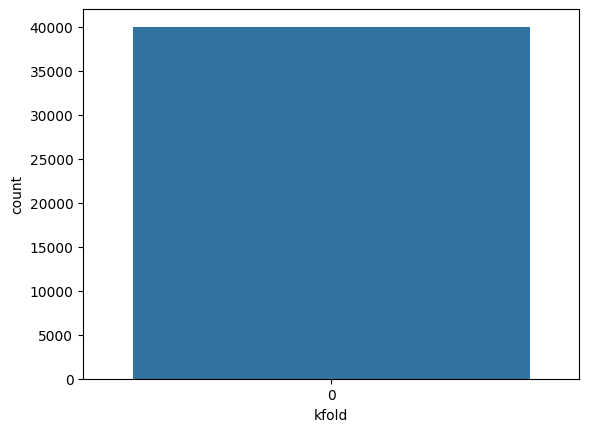

In [ ]:
sns.countplot(x='kfold' , data=df)

In [ ]:
lengths = df['PRODUCT_LENGTH']


bin_edges = pd.qcut(lengths, q=30, duplicates='drop')

class_labels = pd.factorize(bin_edges)[0] + 1

df['class'] = class_labels

class_ranges = df.groupby('class')['PRODUCT_LENGTH'].agg(['min', 'max'])

df['class_range'] = df['class'].map(class_ranges.apply(lambda x: f"{x['min']}-{x['max']}", axis=1))

In [ ]:
df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold,text
0,1505480,"Select settings [100 COUNT] Microwaveable, com...","[INCLUDES: 100 light brown compostable bowls.,...",Your dinnerware matters. It helps to define an...,474,2108,0,select setting 100 count microwaveable compost...
1,2447219,The Customer Service In Africa: How To Improve...,,,6142,12,0,customer service africa improve customer exper...
2,369455,Brentwood (Images of America),,,223,229,0,brentwood image america
3,404896,Claire's Sketch Pad: 50 Blank Pages to draw an...,,,10,81,0,claires sketch pad 50 blank page draw anything...
4,463483,2011/12 Boston Restaurants (Zagat Survey Bosto...,,,12316,68,0,201112 boston restaurant zagat survey boston r...


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import csv
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
import re
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
     



In [ ]:
df=df.fillna(" ")

In [ ]:
X = df['text'].values
y = df['PRODUCT_LENGTH'].values


<Axes: xlabel='class_range', ylabel='PRODUCT_LENGTH'>

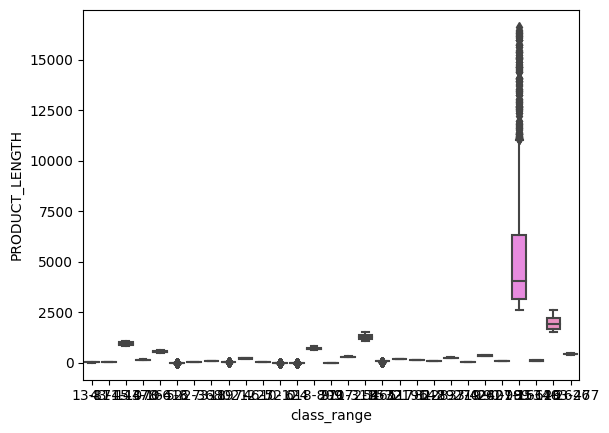

In [ ]:
import seaborn as sns
sns.boxplot(x='class_range',y='PRODUCT_LENGTH',data=df)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(X_train[0])

  (0, 351445)	0.248507452547683
  (0, 351441)	0.248507452547683
  (0, 672009)	0.2347415133407202
  (0, 351438)	0.2347415133407202
  (0, 671150)	0.2098615753582702
  (0, 463788)	0.16399076187253495
  (0, 479306)	0.16515080265958398
  (0, 479199)	0.16427448172958345
  (0, 564761)	0.15401548337509582
  (0, 110233)	0.23475942435004232
  (0, 482573)	0.10485782114014573
  (0, 373442)	0.42217189610734146
  (0, 562395)	0.1245946145666148
  (0, 600724)	0.09715011858163057
  (0, 624956)	0.07355794358703487
  (0, 203334)	0.19082711136741756
  (0, 255495)	0.12081288790845388
  (0, 639660)	0.19827812334482997
  (0, 140394)	0.07722221596821556
  (0, 478801)	0.08912352545729572
  (0, 95962)	0.09755809836214349
  (0, 631468)	0.10043909286465774
  (0, 147888)	0.23491057962042053
  (0, 163103)	0.20507715381850783
  (0, 269926)	0.057803635392759144
  (0, 462287)	0.11310212537760042
  (0, 94358)	0.0869274027797828
  (0, 567628)	0.13357936832107922
  (0, 101687)	0.09688431515603316
  (0, 215409)	0.10285494

In [ ]:
print(X_test)

  (0, 165259)	0.6754423614257279
  (0, 526466)	0.564290134617756
  (0, 361953)	0.29422618401112016
  (0, 209134)	0.26174764638127973
  (0, 366928)	0.2650912722456668
  (1, 543014)	0.131484652693225
  (1, 354457)	0.12420112973619718
  (1, 120621)	0.131484652693225
  (1, 444696)	0.131484652693225
  (1, 378779)	0.3816721946706662
  (1, 164329)	0.07411586069150009
  (1, 601444)	0.46718259725325767
  (1, 391537)	0.07671520941714274
  (1, 600413)	0.0712053105921918
  (1, 31362)	0.32890225146642454
  (1, 592114)	0.05139415759083262
  (1, 290167)	0.06539293503394905
  (1, 508356)	0.4618185106656895
  (1, 184313)	0.05562135840941049
  (1, 301508)	0.047358026529122965
  (1, 412575)	0.054351276570954794
  (1, 88658)	0.05941000295100815
  (1, 249031)	0.06407543963700185
  (1, 482539)	0.05407876566907628
  (1, 394607)	0.09496276163400767
  :	:
  (39999, 353610)	0.041609745839194495
  (39999, 419056)	0.13725085982561416
  (39999, 563234)	0.018717429783990675
  (39999, 134405)	0.16672649274849324
  (

In [ ]:
LR=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
LR.fit(X_train, y_train)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)

In [ ]:
y_pred1 = LR.predict(X_test)


In [ ]:
print(y_pred1)

['46-52' '143-164' '99-116' ... '99-116' '0-4' '10-12']


In [ ]:
accuracy1 = sum(y_test == y_pred1) / len(y_test)
print("Accuracy: {:.2f}%".format(accuracy1 * 100))

Accuracy: 22.79%


In [ ]:
y_pred2 = knn.predict(X_test)

In [ ]:
print(y_pred2)

['10-12' '143-164' '10-12' ... '10-12' '10-12' '10-12']


In [ ]:
accuracy2 = sum(y_test == y_pred2) / len(y_test)
print("Accuracy: {:.2f}%".format(accuracy2 * 100))

Accuracy: 13.73%


In [ ]:
y_pred3 = clf.predict(X_test)

In [ ]:
print(y_pred3)

[   4  116   17 ... 1235  142    4]


In [ ]:
accuracy3 = sum(y_test == y_pred3) / len(y_test)
print("Accuracy: {:.2f}%".format(accuracy3 * 100))

Accuracy: 20.16%
